In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [2]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
hidden_dim = 512

In [3]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [4]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [5]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [6]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [7]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    
    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )
        
        # compute loss terms 
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
                
        loss = loss_recon + loss_kl
        
        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

In [9]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 1,149,972


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [10]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        output = model(data)  # Forward pass
        loss = output.loss
        
        loss.backward()
        
        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  # Update the model parameters
        
    return prev_updates + len(dataloader)

In [12]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data
            
            output = model(data, compute_loss=True)  # Forward pass
            
            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()
            
    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)
        
        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)
        
        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [13]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 543.7048 (Recon: 543.4762, KL: 0.2286) Grad: 13.2013
Step 100 (N samples: 12,800), Loss: 196.5198 (Recon: 194.5638, KL: 1.9560) Grad: 21.2355
Step 200 (N samples: 25,600), Loss: 186.7466 (Recon: 184.7584, KL: 1.9882) Grad: 31.6765
Step 300 (N samples: 38,400), Loss: 182.9304 (Recon: 180.7292, KL: 2.2012) Grad: 44.8083
Step 400 (N samples: 51,200), Loss: 176.5158 (Recon: 172.2812, KL: 4.2346) Grad: 36.1690


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8853 (BCE: 165.7490, KLD: 4.1363)
Epoch 2/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 168.3396 (Recon: 163.9824, KL: 4.3572) Grad: 24.8393
Step 600 (N samples: 76,800), Loss: 169.2694 (Recon: 164.2389, KL: 5.0305) Grad: 50.0920
Step 700 (N samples: 89,600), Loss: 159.4827 (Recon: 154.3652, KL: 5.1175) Grad: 77.7361
Step 800 (N samples: 102,400), Loss: 156.6676 (Recon: 151.4693, KL: 5.1983) Grad: 60.9198
Step 900 (N samples: 115,200), Loss: 155.9932 (Recon: 150.6170, KL: 5.3762) Grad: 84.8388


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 156.9079 (BCE: 151.5833, KLD: 5.3246)
Epoch 3/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 160.3428 (Recon: 155.0218, KL: 5.3209) Grad: 34.6833
Step 1,100 (N samples: 140,800), Loss: 145.4229 (Recon: 139.7427, KL: 5.6802) Grad: 60.7836
Step 1,200 (N samples: 153,600), Loss: 149.6328 (Recon: 144.1265, KL: 5.5063) Grad: 51.5006
Step 1,300 (N samples: 166,400), Loss: 153.8382 (Recon: 148.4472, KL: 5.3910) Grad: 91.0966
Step 1,400 (N samples: 179,200), Loss: 146.5892 (Recon: 140.8667, KL: 5.7225) Grad: 57.4489


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 150.3057 (BCE: 144.4634, KLD: 5.8423)
Epoch 4/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 151.3276 (Recon: 145.5786, KL: 5.7490) Grad: 117.2785
Step 1,600 (N samples: 204,800), Loss: 156.0755 (Recon: 150.2483, KL: 5.8272) Grad: 66.5480
Step 1,700 (N samples: 217,600), Loss: 151.9951 (Recon: 145.8370, KL: 6.1580) Grad: 113.0275
Step 1,800 (N samples: 230,400), Loss: 149.3068 (Recon: 143.4337, KL: 5.8731) Grad: 152.8866


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.5251 (BCE: 141.5370, KLD: 5.9881)
Epoch 5/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 144.5399 (Recon: 138.6205, KL: 5.9194) Grad: 78.7659
Step 2,000 (N samples: 256,000), Loss: 148.4074 (Recon: 142.3671, KL: 6.0403) Grad: 101.1694
Step 2,100 (N samples: 268,800), Loss: 150.8181 (Recon: 144.4301, KL: 6.3880) Grad: 151.9217
Step 2,200 (N samples: 281,600), Loss: 137.3565 (Recon: 131.3414, KL: 6.0151) Grad: 116.1950
Step 2,300 (N samples: 294,400), Loss: 144.4278 (Recon: 138.1924, KL: 6.2354) Grad: 60.5048


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.0126 (BCE: 140.8662, KLD: 6.1464)
Epoch 6/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 150.9198 (Recon: 144.8741, KL: 6.0457) Grad: 66.8309
Step 2,500 (N samples: 320,000), Loss: 144.4348 (Recon: 138.2632, KL: 6.1716) Grad: 195.8959
Step 2,600 (N samples: 332,800), Loss: 136.6637 (Recon: 130.2396, KL: 6.4241) Grad: 85.5595
Step 2,700 (N samples: 345,600), Loss: 141.2538 (Recon: 135.0830, KL: 6.1708) Grad: 102.5864
Step 2,800 (N samples: 358,400), Loss: 147.2599 (Recon: 140.8546, KL: 6.4054) Grad: 136.6756


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.7860 (BCE: 140.8894, KLD: 5.8966)
Epoch 7/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 137.1919 (Recon: 131.0894, KL: 6.1025) Grad: 142.5029
Step 3,000 (N samples: 384,000), Loss: 140.2023 (Recon: 133.9855, KL: 6.2168) Grad: 107.5190
Step 3,100 (N samples: 396,800), Loss: 145.9288 (Recon: 139.6375, KL: 6.2912) Grad: 84.2575
Step 3,200 (N samples: 409,600), Loss: 146.7667 (Recon: 140.5328, KL: 6.2339) Grad: 128.5087


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 143.8185 (BCE: 137.5539, KLD: 6.2646)
Epoch 8/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 147.6974 (Recon: 141.6180, KL: 6.0794) Grad: 73.9894
Step 3,400 (N samples: 435,200), Loss: 146.1953 (Recon: 139.7952, KL: 6.4001) Grad: 166.8121
Step 3,500 (N samples: 448,000), Loss: 146.8763 (Recon: 140.3324, KL: 6.5439) Grad: 130.0259
Step 3,600 (N samples: 460,800), Loss: 145.8895 (Recon: 139.4608, KL: 6.4288) Grad: 113.7227
Step 3,700 (N samples: 473,600), Loss: 145.9583 (Recon: 139.5098, KL: 6.4485) Grad: 75.4957


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.8404 (BCE: 140.5749, KLD: 6.2655)
Epoch 9/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 141.6069 (Recon: 135.5265, KL: 6.0804) Grad: 86.0387
Step 3,900 (N samples: 499,200), Loss: 142.1727 (Recon: 135.9137, KL: 6.2590) Grad: 98.4844
Step 4,000 (N samples: 512,000), Loss: 145.7681 (Recon: 139.3687, KL: 6.3994) Grad: 65.0533
Step 4,100 (N samples: 524,800), Loss: 158.4494 (Recon: 152.3882, KL: 6.0612) Grad: 93.2021
Step 4,200 (N samples: 537,600), Loss: 140.3671 (Recon: 133.7766, KL: 6.5905) Grad: 63.9335


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.8055 (BCE: 136.4567, KLD: 6.3488)
Epoch 10/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 146.9044 (Recon: 140.6806, KL: 6.2238) Grad: 126.6767
Step 4,400 (N samples: 563,200), Loss: 141.1069 (Recon: 134.5308, KL: 6.5761) Grad: 106.7120
Step 4,500 (N samples: 576,000), Loss: 133.0993 (Recon: 126.7942, KL: 6.3051) Grad: 187.8675
Step 4,600 (N samples: 588,800), Loss: 141.4569 (Recon: 134.8969, KL: 6.5600) Grad: 123.4931


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.3734 (BCE: 135.9460, KLD: 6.4274)
Epoch 11/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,700 (N samples: 601,600), Loss: 145.2776 (Recon: 138.8967, KL: 6.3809) Grad: 91.9439
Step 4,800 (N samples: 614,400), Loss: 149.6145 (Recon: 143.3522, KL: 6.2623) Grad: 115.9410
Step 4,900 (N samples: 627,200), Loss: 142.7873 (Recon: 136.3270, KL: 6.4602) Grad: 83.0165
Step 5,000 (N samples: 640,000), Loss: 139.1461 (Recon: 132.5687, KL: 6.5775) Grad: 106.9743
Step 5,100 (N samples: 652,800), Loss: 139.4943 (Recon: 133.0864, KL: 6.4079) Grad: 139.1568


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.3357 (BCE: 134.8020, KLD: 6.5337)
Epoch 12/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,200 (N samples: 665,600), Loss: 139.7879 (Recon: 133.4388, KL: 6.3491) Grad: 82.3641
Step 5,300 (N samples: 678,400), Loss: 147.8822 (Recon: 141.5745, KL: 6.3077) Grad: 130.7881
Step 5,400 (N samples: 691,200), Loss: 145.7626 (Recon: 139.4881, KL: 6.2746) Grad: 98.5171
Step 5,500 (N samples: 704,000), Loss: 140.6974 (Recon: 134.2719, KL: 6.4255) Grad: 113.6408
Step 5,600 (N samples: 716,800), Loss: 138.5033 (Recon: 132.1035, KL: 6.3997) Grad: 66.7633


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.0546 (BCE: 135.5246, KLD: 6.5300)
Epoch 13/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 5,700 (N samples: 729,600), Loss: 146.4180 (Recon: 140.1006, KL: 6.3174) Grad: 108.0676
Step 5,800 (N samples: 742,400), Loss: 145.4617 (Recon: 138.9333, KL: 6.5284) Grad: 76.1477
Step 5,900 (N samples: 755,200), Loss: 137.6232 (Recon: 131.0583, KL: 6.5649) Grad: 89.6250
Step 6,000 (N samples: 768,000), Loss: 143.8716 (Recon: 137.2554, KL: 6.6162) Grad: 185.2512


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.0512 (BCE: 134.7559, KLD: 6.2953)
Epoch 14/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,100 (N samples: 780,800), Loss: 145.2072 (Recon: 138.8546, KL: 6.3526) Grad: 108.4106
Step 6,200 (N samples: 793,600), Loss: 138.6536 (Recon: 132.1749, KL: 6.4787) Grad: 75.1398
Step 6,300 (N samples: 806,400), Loss: 139.5411 (Recon: 133.1853, KL: 6.3559) Grad: 119.8694
Step 6,400 (N samples: 819,200), Loss: 144.4910 (Recon: 137.6571, KL: 6.8339) Grad: 175.8920
Step 6,500 (N samples: 832,000), Loss: 140.4928 (Recon: 133.9371, KL: 6.5558) Grad: 103.2861


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.2691 (BCE: 133.8672, KLD: 6.4020)
Epoch 15/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 6,600 (N samples: 844,800), Loss: 129.8029 (Recon: 123.0569, KL: 6.7460) Grad: 122.2619
Step 6,700 (N samples: 857,600), Loss: 142.4309 (Recon: 135.7847, KL: 6.6463) Grad: 223.1462
Step 6,800 (N samples: 870,400), Loss: 144.6777 (Recon: 138.1559, KL: 6.5219) Grad: 125.8325
Step 6,900 (N samples: 883,200), Loss: 140.0967 (Recon: 133.5003, KL: 6.5965) Grad: 121.8096
Step 7,000 (N samples: 896,000), Loss: 142.2392 (Recon: 135.6584, KL: 6.5808) Grad: 86.5851


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.0035 (BCE: 133.5143, KLD: 6.4892)
Epoch 16/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,100 (N samples: 908,800), Loss: 146.7273 (Recon: 140.1039, KL: 6.6234) Grad: 101.1116
Step 7,200 (N samples: 921,600), Loss: 129.4795 (Recon: 122.8976, KL: 6.5820) Grad: 118.5637
Step 7,300 (N samples: 934,400), Loss: 143.1250 (Recon: 136.6190, KL: 6.5060) Grad: 101.7828
Step 7,400 (N samples: 947,200), Loss: 141.0944 (Recon: 134.4795, KL: 6.6149) Grad: 89.9142
Step 7,500 (N samples: 960,000), Loss: 140.0466 (Recon: 133.3853, KL: 6.6613) Grad: 112.4655


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.5137 (BCE: 133.8728, KLD: 6.6409)
Epoch 17/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 7,600 (N samples: 972,800), Loss: 141.2692 (Recon: 134.4563, KL: 6.8129) Grad: 168.8241
Step 7,700 (N samples: 985,600), Loss: 141.2679 (Recon: 134.7126, KL: 6.5552) Grad: 96.3398
Step 7,800 (N samples: 998,400), Loss: 141.2598 (Recon: 134.5931, KL: 6.6668) Grad: 109.4918
Step 7,900 (N samples: 1,011,200), Loss: 145.9612 (Recon: 139.3267, KL: 6.6345) Grad: 100.4487


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.8236 (BCE: 133.2588, KLD: 6.5648)
Epoch 18/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,000 (N samples: 1,024,000), Loss: 143.4752 (Recon: 136.6182, KL: 6.8570) Grad: 139.6462
Step 8,100 (N samples: 1,036,800), Loss: 139.7189 (Recon: 133.0831, KL: 6.6358) Grad: 65.2828
Step 8,200 (N samples: 1,049,600), Loss: 134.6259 (Recon: 128.1027, KL: 6.5232) Grad: 145.6446
Step 8,300 (N samples: 1,062,400), Loss: 139.3652 (Recon: 132.7960, KL: 6.5692) Grad: 169.5791
Step 8,400 (N samples: 1,075,200), Loss: 145.0817 (Recon: 138.5423, KL: 6.5395) Grad: 154.1462


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.4445 (BCE: 133.8600, KLD: 6.5844)
Epoch 19/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 8,500 (N samples: 1,088,000), Loss: 141.6868 (Recon: 135.0914, KL: 6.5954) Grad: 103.3442
Step 8,600 (N samples: 1,100,800), Loss: 136.6631 (Recon: 129.9710, KL: 6.6921) Grad: 124.2313
Step 8,700 (N samples: 1,113,600), Loss: 152.6920 (Recon: 146.1937, KL: 6.4983) Grad: 131.6559
Step 8,800 (N samples: 1,126,400), Loss: 139.2555 (Recon: 132.6044, KL: 6.6511) Grad: 103.8900
Step 8,900 (N samples: 1,139,200), Loss: 141.1490 (Recon: 134.5138, KL: 6.6352) Grad: 116.0507


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.9028 (BCE: 141.4983, KLD: 6.4044)
Epoch 20/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,000 (N samples: 1,152,000), Loss: 147.6687 (Recon: 141.1444, KL: 6.5243) Grad: 271.4680
Step 9,100 (N samples: 1,164,800), Loss: 142.6934 (Recon: 136.2182, KL: 6.4751) Grad: 91.8642
Step 9,200 (N samples: 1,177,600), Loss: 138.9370 (Recon: 132.3510, KL: 6.5861) Grad: 126.9413
Step 9,300 (N samples: 1,190,400), Loss: 143.1819 (Recon: 136.4650, KL: 6.7169) Grad: 120.9794


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.0945 (BCE: 134.3660, KLD: 6.7285)
Epoch 21/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,400 (N samples: 1,203,200), Loss: 137.8222 (Recon: 130.9759, KL: 6.8463) Grad: 137.5432
Step 9,500 (N samples: 1,216,000), Loss: 131.0684 (Recon: 124.5175, KL: 6.5509) Grad: 103.9371
Step 9,600 (N samples: 1,228,800), Loss: 141.7269 (Recon: 135.0978, KL: 6.6291) Grad: 106.1813
Step 9,700 (N samples: 1,241,600), Loss: 142.6924 (Recon: 135.8566, KL: 6.8358) Grad: 143.5911
Step 9,800 (N samples: 1,254,400), Loss: 145.3864 (Recon: 138.9301, KL: 6.4563) Grad: 132.9273


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.8529 (BCE: 136.3473, KLD: 6.5056)
Epoch 22/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 9,900 (N samples: 1,267,200), Loss: 150.9961 (Recon: 144.2717, KL: 6.7244) Grad: 159.6516
Step 10,000 (N samples: 1,280,000), Loss: 142.3554 (Recon: 135.4579, KL: 6.8975) Grad: 155.0556
Step 10,100 (N samples: 1,292,800), Loss: 142.8204 (Recon: 136.2455, KL: 6.5748) Grad: 115.6572
Step 10,200 (N samples: 1,305,600), Loss: 137.6063 (Recon: 130.9871, KL: 6.6191) Grad: 139.4903
Step 10,300 (N samples: 1,318,400), Loss: 147.1358 (Recon: 140.3954, KL: 6.7404) Grad: 88.0361


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.5954 (BCE: 134.9583, KLD: 6.6371)
Epoch 23/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,400 (N samples: 1,331,200), Loss: 139.0049 (Recon: 132.3201, KL: 6.6848) Grad: 168.2124
Step 10,500 (N samples: 1,344,000), Loss: 140.1605 (Recon: 133.3395, KL: 6.8210) Grad: 164.1197
Step 10,600 (N samples: 1,356,800), Loss: 143.6708 (Recon: 136.8352, KL: 6.8356) Grad: 183.0555
Step 10,700 (N samples: 1,369,600), Loss: 138.6699 (Recon: 131.8878, KL: 6.7820) Grad: 171.5523


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 142.9193 (BCE: 136.2868, KLD: 6.6324)
Epoch 24/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 10,800 (N samples: 1,382,400), Loss: 142.7622 (Recon: 136.0945, KL: 6.6678) Grad: 181.0229
Step 10,900 (N samples: 1,395,200), Loss: 140.3210 (Recon: 133.5305, KL: 6.7906) Grad: 88.3012
Step 11,000 (N samples: 1,408,000), Loss: 141.0413 (Recon: 134.1158, KL: 6.9256) Grad: 116.9960
Step 11,100 (N samples: 1,420,800), Loss: 140.1191 (Recon: 133.3317, KL: 6.7875) Grad: 145.3277
Step 11,200 (N samples: 1,433,600), Loss: 140.0468 (Recon: 133.3014, KL: 6.7454) Grad: 144.7922


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.6358 (BCE: 133.0089, KLD: 6.6270)
Epoch 25/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,300 (N samples: 1,446,400), Loss: 136.4509 (Recon: 129.7424, KL: 6.7086) Grad: 119.3495
Step 11,400 (N samples: 1,459,200), Loss: 145.9622 (Recon: 139.2060, KL: 6.7561) Grad: 226.1065
Step 11,500 (N samples: 1,472,000), Loss: 145.5706 (Recon: 138.6479, KL: 6.9226) Grad: 265.4032
Step 11,600 (N samples: 1,484,800), Loss: 133.1946 (Recon: 126.3108, KL: 6.8838) Grad: 97.3911
Step 11,700 (N samples: 1,497,600), Loss: 141.2453 (Recon: 134.6247, KL: 6.6206) Grad: 186.0734


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.9423 (BCE: 134.2302, KLD: 6.7120)
Epoch 26/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 11,800 (N samples: 1,510,400), Loss: 136.2242 (Recon: 129.4988, KL: 6.7254) Grad: 126.1064
Step 11,900 (N samples: 1,523,200), Loss: 135.5735 (Recon: 128.7946, KL: 6.7789) Grad: 78.9959
Step 12,000 (N samples: 1,536,000), Loss: 138.3947 (Recon: 131.4825, KL: 6.9123) Grad: 158.5856
Step 12,100 (N samples: 1,548,800), Loss: 135.5496 (Recon: 128.8279, KL: 6.7217) Grad: 145.8542


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.6361 (BCE: 134.7673, KLD: 6.8688)
Epoch 27/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,200 (N samples: 1,561,600), Loss: 146.8106 (Recon: 140.0636, KL: 6.7470) Grad: 142.7703
Step 12,300 (N samples: 1,574,400), Loss: 134.8477 (Recon: 128.0092, KL: 6.8386) Grad: 136.5291
Step 12,400 (N samples: 1,587,200), Loss: 151.4770 (Recon: 144.9291, KL: 6.5479) Grad: 169.6821
Step 12,500 (N samples: 1,600,000), Loss: 140.0463 (Recon: 133.2725, KL: 6.7738) Grad: 144.2533
Step 12,600 (N samples: 1,612,800), Loss: 141.1278 (Recon: 134.3969, KL: 6.7309) Grad: 113.3016


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.7125 (BCE: 133.8534, KLD: 6.8591)
Epoch 28/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 12,700 (N samples: 1,625,600), Loss: 142.2102 (Recon: 135.4335, KL: 6.7767) Grad: 141.5959
Step 12,800 (N samples: 1,638,400), Loss: 141.9455 (Recon: 135.1024, KL: 6.8431) Grad: 160.0606
Step 12,900 (N samples: 1,651,200), Loss: 134.6839 (Recon: 127.7607, KL: 6.9231) Grad: 136.1254
Step 13,000 (N samples: 1,664,000), Loss: 143.8727 (Recon: 137.0030, KL: 6.8698) Grad: 171.0563
Step 13,100 (N samples: 1,676,800), Loss: 138.1586 (Recon: 131.1895, KL: 6.9691) Grad: 113.8871


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.5692 (BCE: 132.8897, KLD: 6.6795)
Epoch 29/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,200 (N samples: 1,689,600), Loss: 141.0663 (Recon: 134.0033, KL: 7.0630) Grad: 276.9816
Step 13,300 (N samples: 1,702,400), Loss: 140.2404 (Recon: 133.5340, KL: 6.7064) Grad: 161.1047
Step 13,400 (N samples: 1,715,200), Loss: 142.2063 (Recon: 135.2843, KL: 6.9220) Grad: 172.8699
Step 13,500 (N samples: 1,728,000), Loss: 137.9860 (Recon: 131.0197, KL: 6.9663) Grad: 126.0962
Step 13,600 (N samples: 1,740,800), Loss: 146.1092 (Recon: 139.2979, KL: 6.8113) Grad: 186.0620


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 145.1936 (BCE: 138.4198, KLD: 6.7738)
Epoch 30/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 13,700 (N samples: 1,753,600), Loss: 141.1622 (Recon: 134.5558, KL: 6.6064) Grad: 178.2161
Step 13,800 (N samples: 1,766,400), Loss: 143.4299 (Recon: 136.6135, KL: 6.8164) Grad: 147.4554
Step 13,900 (N samples: 1,779,200), Loss: 135.6770 (Recon: 128.9194, KL: 6.7577) Grad: 145.8493
Step 14,000 (N samples: 1,792,000), Loss: 146.8365 (Recon: 139.9265, KL: 6.9101) Grad: 314.4178


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.9090 (BCE: 132.1919, KLD: 6.7171)
Epoch 31/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,100 (N samples: 1,804,800), Loss: 136.1463 (Recon: 129.4201, KL: 6.7262) Grad: 178.6429
Step 14,200 (N samples: 1,817,600), Loss: 140.4645 (Recon: 133.5904, KL: 6.8740) Grad: 184.1216
Step 14,300 (N samples: 1,830,400), Loss: 133.0950 (Recon: 126.2400, KL: 6.8550) Grad: 169.6895
Step 14,400 (N samples: 1,843,200), Loss: 149.6138 (Recon: 143.0322, KL: 6.5816) Grad: 157.9171
Step 14,500 (N samples: 1,856,000), Loss: 141.0541 (Recon: 134.3041, KL: 6.7500) Grad: 239.1494


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.2086 (BCE: 134.4180, KLD: 6.7906)
Epoch 32/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 14,600 (N samples: 1,868,800), Loss: 136.8258 (Recon: 129.9237, KL: 6.9021) Grad: 86.0160
Step 14,700 (N samples: 1,881,600), Loss: 142.3799 (Recon: 135.3833, KL: 6.9966) Grad: 136.0845
Step 14,800 (N samples: 1,894,400), Loss: 145.3188 (Recon: 138.5857, KL: 6.7331) Grad: 150.6294
Step 14,900 (N samples: 1,907,200), Loss: 141.9359 (Recon: 135.1810, KL: 6.7548) Grad: 224.5821
Step 15,000 (N samples: 1,920,000), Loss: 142.2363 (Recon: 135.2825, KL: 6.9538) Grad: 161.9659


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.1244 (BCE: 132.3546, KLD: 6.7698)
Epoch 33/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,100 (N samples: 1,932,800), Loss: 132.8798 (Recon: 125.8634, KL: 7.0164) Grad: 133.1709
Step 15,200 (N samples: 1,945,600), Loss: 136.4046 (Recon: 129.5659, KL: 6.8388) Grad: 166.3442
Step 15,300 (N samples: 1,958,400), Loss: 138.9777 (Recon: 131.9478, KL: 7.0299) Grad: 142.3802
Step 15,400 (N samples: 1,971,200), Loss: 138.0589 (Recon: 131.1905, KL: 6.8684) Grad: 183.4787


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.9568 (BCE: 132.0162, KLD: 6.9406)
Epoch 34/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 15,500 (N samples: 1,984,000), Loss: 140.4902 (Recon: 133.4458, KL: 7.0445) Grad: 152.8814
Step 15,600 (N samples: 1,996,800), Loss: 142.6179 (Recon: 135.6242, KL: 6.9937) Grad: 174.4343
Step 15,700 (N samples: 2,009,600), Loss: 143.9796 (Recon: 137.0056, KL: 6.9740) Grad: 139.5561
Step 15,800 (N samples: 2,022,400), Loss: 136.7017 (Recon: 129.8264, KL: 6.8754) Grad: 213.4159
Step 15,900 (N samples: 2,035,200), Loss: 139.1045 (Recon: 132.1281, KL: 6.9763) Grad: 203.4645


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.0680 (BCE: 131.1834, KLD: 6.8846)
Epoch 35/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,000 (N samples: 2,048,000), Loss: 139.2834 (Recon: 132.3785, KL: 6.9049) Grad: 115.8006
Step 16,100 (N samples: 2,060,800), Loss: 144.9014 (Recon: 138.0575, KL: 6.8439) Grad: 97.1368
Step 16,200 (N samples: 2,073,600), Loss: 145.4338 (Recon: 138.4505, KL: 6.9833) Grad: 115.7542
Step 16,300 (N samples: 2,086,400), Loss: 140.6963 (Recon: 133.7998, KL: 6.8964) Grad: 205.6426
Step 16,400 (N samples: 2,099,200), Loss: 133.6434 (Recon: 126.8449, KL: 6.7985) Grad: 128.0290


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.7895 (BCE: 131.8788, KLD: 6.9107)
Epoch 36/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,500 (N samples: 2,112,000), Loss: 138.7085 (Recon: 131.6432, KL: 7.0653) Grad: 139.7414
Step 16,600 (N samples: 2,124,800), Loss: 138.6994 (Recon: 131.6022, KL: 7.0973) Grad: 153.1480
Step 16,700 (N samples: 2,137,600), Loss: 134.7372 (Recon: 127.8307, KL: 6.9065) Grad: 265.8904
Step 16,800 (N samples: 2,150,400), Loss: 138.9289 (Recon: 131.9547, KL: 6.9741) Grad: 117.6848


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2833 (BCE: 132.3758, KLD: 6.9075)
Epoch 37/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 16,900 (N samples: 2,163,200), Loss: 146.2417 (Recon: 139.2360, KL: 7.0058) Grad: 139.2653
Step 17,000 (N samples: 2,176,000), Loss: 136.4805 (Recon: 129.6466, KL: 6.8339) Grad: 174.1234
Step 17,100 (N samples: 2,188,800), Loss: 147.0758 (Recon: 140.1812, KL: 6.8946) Grad: 128.9763
Step 17,200 (N samples: 2,201,600), Loss: 131.4410 (Recon: 124.5014, KL: 6.9396) Grad: 170.4381
Step 17,300 (N samples: 2,214,400), Loss: 138.3421 (Recon: 131.5705, KL: 6.7716) Grad: 208.8953


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.4506 (BCE: 132.4810, KLD: 6.9696)
Epoch 38/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,400 (N samples: 2,227,200), Loss: 148.0538 (Recon: 141.1085, KL: 6.9453) Grad: 128.2328
Step 17,500 (N samples: 2,240,000), Loss: 130.4629 (Recon: 123.5430, KL: 6.9198) Grad: 306.0978
Step 17,600 (N samples: 2,252,800), Loss: 135.4276 (Recon: 128.5310, KL: 6.8966) Grad: 196.2778
Step 17,700 (N samples: 2,265,600), Loss: 146.4793 (Recon: 139.7151, KL: 6.7642) Grad: 187.4790
Step 17,800 (N samples: 2,278,400), Loss: 141.7197 (Recon: 134.6684, KL: 7.0513) Grad: 174.8350


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.3862 (BCE: 131.4625, KLD: 6.9238)
Epoch 39/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 17,900 (N samples: 2,291,200), Loss: 130.8113 (Recon: 123.9116, KL: 6.8997) Grad: 130.9031
Step 18,000 (N samples: 2,304,000), Loss: 136.4509 (Recon: 129.5052, KL: 6.9457) Grad: 127.3865
Step 18,100 (N samples: 2,316,800), Loss: 150.1588 (Recon: 143.5376, KL: 6.6213) Grad: 195.9227
Step 18,200 (N samples: 2,329,600), Loss: 142.7022 (Recon: 135.7010, KL: 7.0012) Grad: 182.9051


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.2813 (BCE: 132.3286, KLD: 6.9527)
Epoch 40/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,300 (N samples: 2,342,400), Loss: 141.5678 (Recon: 134.6652, KL: 6.9027) Grad: 316.5970
Step 18,400 (N samples: 2,355,200), Loss: 137.7483 (Recon: 130.9575, KL: 6.7908) Grad: 212.9486
Step 18,500 (N samples: 2,368,000), Loss: 134.3249 (Recon: 127.4371, KL: 6.8878) Grad: 141.4871
Step 18,600 (N samples: 2,380,800), Loss: 139.1979 (Recon: 132.0472, KL: 7.1506) Grad: 162.9960
Step 18,700 (N samples: 2,393,600), Loss: 140.0360 (Recon: 132.8462, KL: 7.1898) Grad: 151.0664


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.0314 (BCE: 131.0318, KLD: 6.9996)
Epoch 41/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 18,800 (N samples: 2,406,400), Loss: 138.8611 (Recon: 131.8653, KL: 6.9958) Grad: 138.4361
Step 18,900 (N samples: 2,419,200), Loss: 141.2829 (Recon: 134.2554, KL: 7.0275) Grad: 138.9389
Step 19,000 (N samples: 2,432,000), Loss: 138.8879 (Recon: 131.8669, KL: 7.0210) Grad: 84.7113
Step 19,100 (N samples: 2,444,800), Loss: 137.1960 (Recon: 130.1597, KL: 7.0363) Grad: 156.5418
Step 19,200 (N samples: 2,457,600), Loss: 141.2852 (Recon: 134.2583, KL: 7.0269) Grad: 206.0808


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.7309 (BCE: 132.7892, KLD: 6.9418)
Epoch 42/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,300 (N samples: 2,470,400), Loss: 138.0187 (Recon: 131.0231, KL: 6.9956) Grad: 282.7733
Step 19,400 (N samples: 2,483,200), Loss: 137.2608 (Recon: 130.2956, KL: 6.9652) Grad: 185.0653
Step 19,500 (N samples: 2,496,000), Loss: 145.5657 (Recon: 138.5428, KL: 7.0229) Grad: 148.8547
Step 19,600 (N samples: 2,508,800), Loss: 137.5811 (Recon: 130.5324, KL: 7.0488) Grad: 234.6668


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.3489 (BCE: 131.3509, KLD: 6.9980)
Epoch 43/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 19,700 (N samples: 2,521,600), Loss: 139.3511 (Recon: 132.2320, KL: 7.1191) Grad: 183.7896
Step 19,800 (N samples: 2,534,400), Loss: 136.0023 (Recon: 129.1793, KL: 6.8229) Grad: 178.4191
Step 19,900 (N samples: 2,547,200), Loss: 136.5727 (Recon: 129.7227, KL: 6.8500) Grad: 160.7042
Step 20,000 (N samples: 2,560,000), Loss: 133.5147 (Recon: 126.2960, KL: 7.2187) Grad: 230.8436
Step 20,100 (N samples: 2,572,800), Loss: 137.6826 (Recon: 130.6099, KL: 7.0727) Grad: 142.3874


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.4738 (BCE: 134.7164, KLD: 6.7575)
Epoch 44/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,200 (N samples: 2,585,600), Loss: 144.9781 (Recon: 138.3501, KL: 6.6279) Grad: 191.5695
Step 20,300 (N samples: 2,598,400), Loss: 141.9046 (Recon: 134.7313, KL: 7.1734) Grad: 287.0201
Step 20,400 (N samples: 2,611,200), Loss: 136.5102 (Recon: 129.6729, KL: 6.8373) Grad: 170.7583
Step 20,500 (N samples: 2,624,000), Loss: 146.2093 (Recon: 139.2739, KL: 6.9354) Grad: 145.7581
Step 20,600 (N samples: 2,636,800), Loss: 135.1221 (Recon: 128.0932, KL: 7.0289) Grad: 190.3987


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 139.5737 (BCE: 132.4459, KLD: 7.1278)
Epoch 45/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 20,700 (N samples: 2,649,600), Loss: 137.0842 (Recon: 130.0238, KL: 7.0603) Grad: 185.4637
Step 20,800 (N samples: 2,662,400), Loss: 133.7303 (Recon: 126.6209, KL: 7.1094) Grad: 192.0251
Step 20,900 (N samples: 2,675,200), Loss: 131.3439 (Recon: 124.2816, KL: 7.0623) Grad: 166.5940
Step 21,000 (N samples: 2,688,000), Loss: 143.5925 (Recon: 136.7185, KL: 6.8740) Grad: 212.6290
Step 21,100 (N samples: 2,700,800), Loss: 139.4092 (Recon: 132.4059, KL: 7.0033) Grad: 127.5906


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 141.7560 (BCE: 134.9040, KLD: 6.8520)
Epoch 46/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,200 (N samples: 2,713,600), Loss: 146.9552 (Recon: 140.1158, KL: 6.8394) Grad: 204.1757
Step 21,300 (N samples: 2,726,400), Loss: 142.9586 (Recon: 135.9534, KL: 7.0051) Grad: 151.8454
Step 21,400 (N samples: 2,739,200), Loss: 147.1719 (Recon: 140.2000, KL: 6.9719) Grad: 178.9965
Step 21,500 (N samples: 2,752,000), Loss: 139.4339 (Recon: 132.3182, KL: 7.1157) Grad: 137.6378


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 138.6621 (BCE: 131.6148, KLD: 7.0473)
Epoch 47/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 21,600 (N samples: 2,764,800), Loss: 139.6607 (Recon: 132.6580, KL: 7.0027) Grad: 217.1929
Step 21,700 (N samples: 2,777,600), Loss: 136.0542 (Recon: 129.0676, KL: 6.9866) Grad: 224.7891
Step 21,800 (N samples: 2,790,400), Loss: 137.0970 (Recon: 130.0340, KL: 7.0630) Grad: 165.4292
Step 21,900 (N samples: 2,803,200), Loss: 140.5549 (Recon: 133.5752, KL: 6.9797) Grad: 102.7492
Step 22,000 (N samples: 2,816,000), Loss: 131.3966 (Recon: 124.2529, KL: 7.1436) Grad: 166.4771


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.3333 (BCE: 130.2601, KLD: 7.0732)
Epoch 48/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,100 (N samples: 2,828,800), Loss: 139.8607 (Recon: 132.7385, KL: 7.1222) Grad: 166.5395
Step 22,200 (N samples: 2,841,600), Loss: 133.7758 (Recon: 126.7136, KL: 7.0622) Grad: 214.4141
Step 22,300 (N samples: 2,854,400), Loss: 135.2918 (Recon: 128.3356, KL: 6.9562) Grad: 169.1566
Step 22,400 (N samples: 2,867,200), Loss: 138.3312 (Recon: 131.4477, KL: 6.8835) Grad: 229.7477
Step 22,500 (N samples: 2,880,000), Loss: 143.0625 (Recon: 135.9982, KL: 7.0643) Grad: 180.9144


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 140.2811 (BCE: 133.3579, KLD: 6.9233)
Epoch 49/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 22,600 (N samples: 2,892,800), Loss: 126.0150 (Recon: 119.0123, KL: 7.0026) Grad: 180.9364
Step 22,700 (N samples: 2,905,600), Loss: 136.3844 (Recon: 129.3215, KL: 7.0630) Grad: 236.6741
Step 22,800 (N samples: 2,918,400), Loss: 134.0231 (Recon: 127.0980, KL: 6.9251) Grad: 144.1920
Step 22,900 (N samples: 2,931,200), Loss: 142.8106 (Recon: 135.6681, KL: 7.1425) Grad: 634.6072


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.6443 (BCE: 130.6137, KLD: 7.0307)
Epoch 50/50


  0%|          | 0/469 [00:00<?, ?it/s]

Step 23,000 (N samples: 2,944,000), Loss: 139.4646 (Recon: 132.3943, KL: 7.0703) Grad: 236.1837
Step 23,100 (N samples: 2,956,800), Loss: 140.2522 (Recon: 133.1442, KL: 7.1080) Grad: 201.0696
Step 23,200 (N samples: 2,969,600), Loss: 139.0853 (Recon: 131.9283, KL: 7.1571) Grad: 139.7950
Step 23,300 (N samples: 2,982,400), Loss: 139.1910 (Recon: 132.1145, KL: 7.0766) Grad: 262.9923
Step 23,400 (N samples: 2,995,200), Loss: 138.8049 (Recon: 131.8653, KL: 6.9397) Grad: 230.4735


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 137.7486 (BCE: 130.7495, KLD: 6.9991)


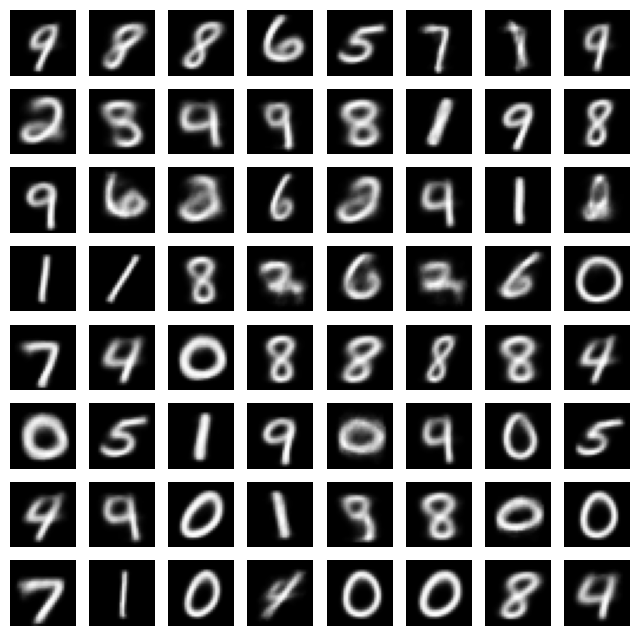

In [14]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [15]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding:   0%|          | 0/469 [00:00<?, ?it/s]

In [16]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

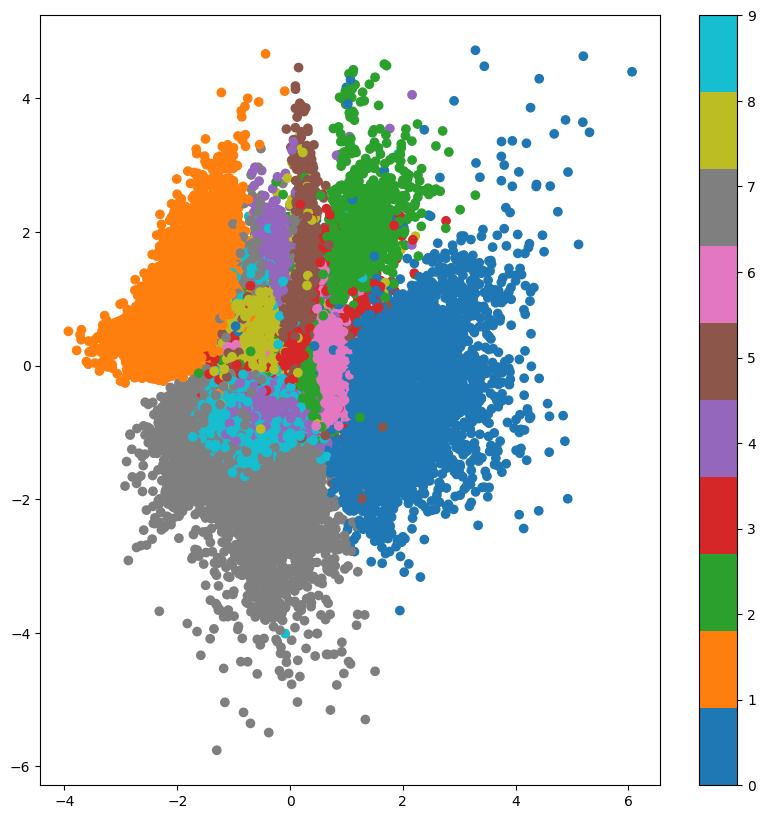

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

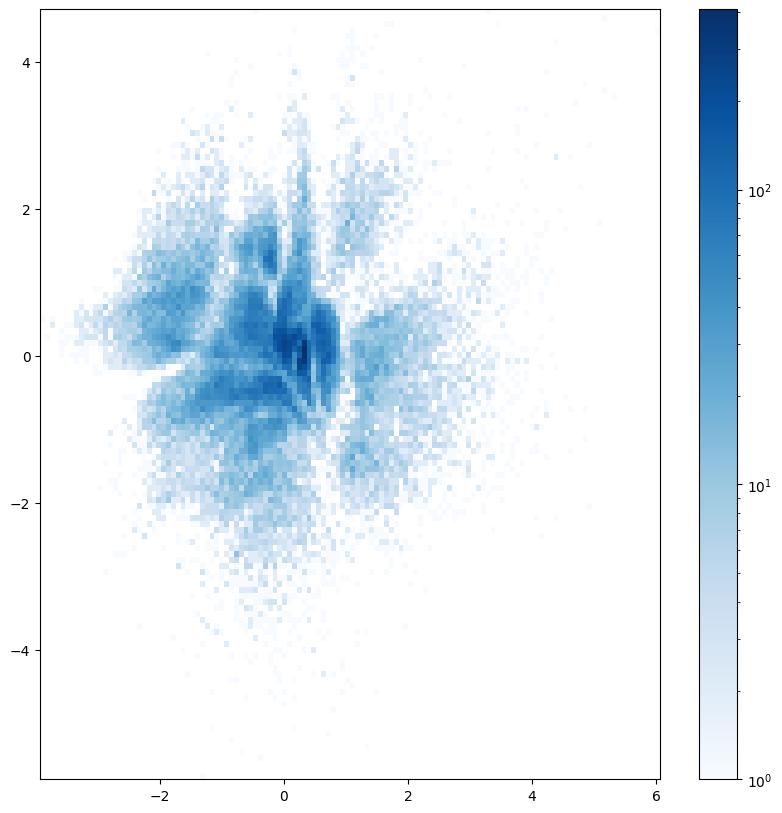

In [18]:

# plot as 2d histogram, log scale
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(z_all[:, 0], z_all[:, 1], bins=128, cmap='Blues', norm=LogNorm())
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_hist.webp')

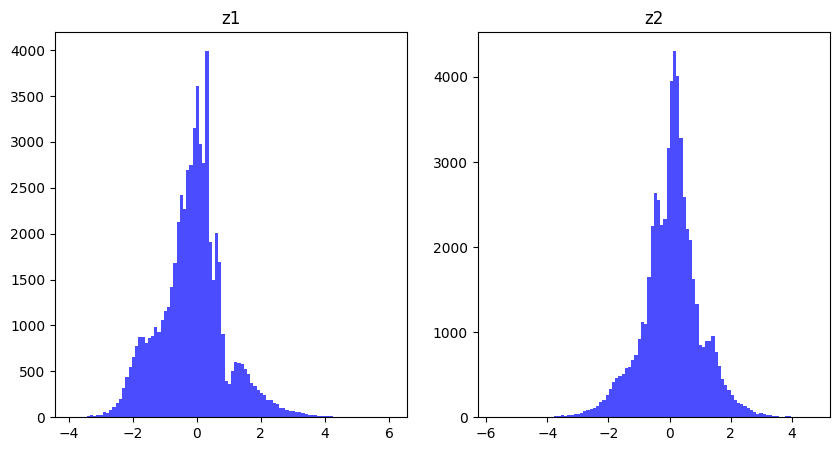

In [19]:
# plot 1d histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(z_all[:, 0], bins=100, color='b', alpha=0.7)
ax[0].set_title('z1')
ax[1].hist(z_all[:, 1], bins=100, color='b', alpha=0.7)
ax[1].set_title('z2')
# plt.show()
plt.savefig('vae_mnist_1d_hist.webp')

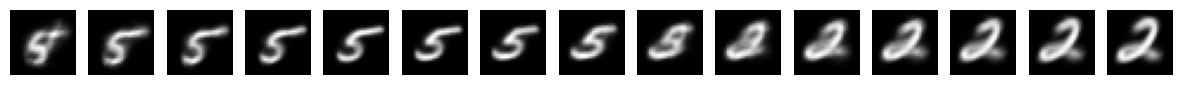

In [20]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')

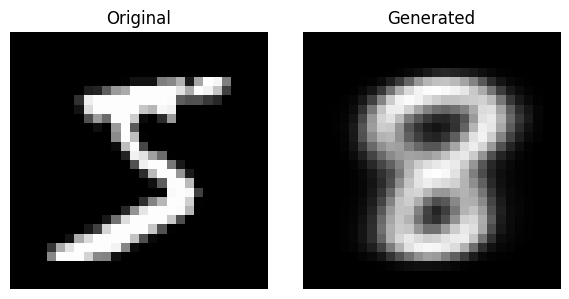

In [31]:
# Take a single record from the dataset
sample_img, sample_label = train_data[0]
sample_img = sample_img.to(device).view(1, -1)

# 1. Encode: get z distribution and sample z
model.eval()
with torch.no_grad():
    encoded = model(sample_img, compute_loss=False)
    z_encoded = encoded.z_sample  # shape: [1, latent_dim]

# 2. Perturb z (e.g., add small noise)
z_new = z_encoded + torch.randn_like(z_encoded) * 0.5

# 3. Decode z to generate a new result
with torch.no_grad():
    decoded = model.decode(z_new)
    decoded_img = decoded.view(28, 28).cpu().numpy()

# Plot original and generated images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample_img.view(28, 28).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Generated")
plt.imshow(decoded_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
#save the model
torch.save(model.state_dict(), 'vae_mnist.pth')
print('Model saved to vae_mnist.pth')

Model saved to vae_mnist.pth
